## A Probabilistic Policy
We develop a policy function that maps a board to a probabilistic distribution over good actions. We use the heuristic scoring system from ```HeuristicPolicy.py``` and ```Heuristic.py```. The trick is to have a prioritized approach that considers the criticality categories top down. Only if there's no field belonging to a higher category, then any lower category or the original score can be considered. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from wgomoku import (
    GomokuBoard, Move, StochasticMaxSampler, HeuristicGomokuPolicy, 
    ThreatSearch, Heuristics, GomokuTools as gt)


In [3]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

In [4]:
h = Heuristics(kappa=3.0)

In [5]:
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ThreatSearch(5,3))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10);

The probabilistic distribution is provided by ```HeuristicGomokuPolicy.probas```

In [6]:
import inspect
lines = inspect.getsource(HeuristicGomokuPolicy.probas)
print(lines)

    def probas (self, board, style):
        """    
        Returns the (suggested) probabilities for a move to be taken.
        In case, masks all but the positions belonging to the most critical category. 
        Params:
        board: a gomoku board.
        style: 0=aggressive, 1=defensive, 2=mixed
        In non-critical situations, style = 0 looks at offensive options only,
        style = 1 looks at defensive options only and style = 2 considers both aspects
        equally.
        """
        scores = board.get_clean_scores()
        to_move = 1 - board.current_color
        o = scores[to_move]
        d = scores[1 - to_move]

        criticals = [lambda: o > 7.0, lambda: d > 7.0,
                     lambda: o == 7.0, lambda: d == 7.0,
                     lambda: o == 6.9, lambda: d == 6.9]

        for crit in criticals:
            field = crit()
            if field.any():
                return field / field.sum()

        if style == 0:
            noncrit = scores[t

-5.050153242075339

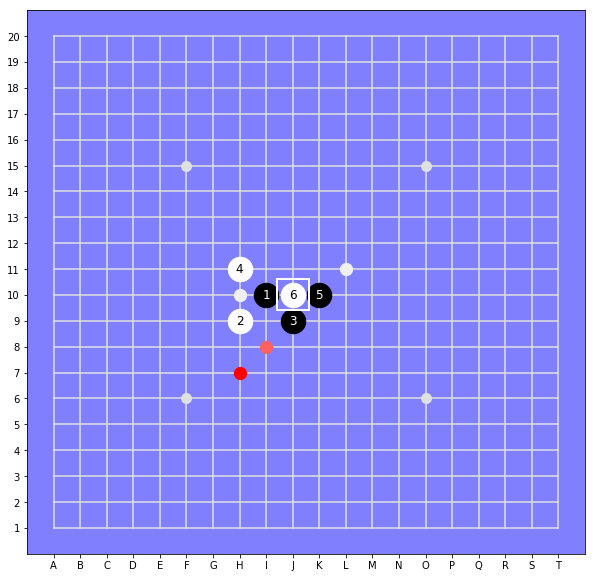

In [7]:
board.display(probas=lambda x: p.probas(x, 2))
board.get_value(True)

In [8]:
board.set(H, 7);

-30.72068268501276

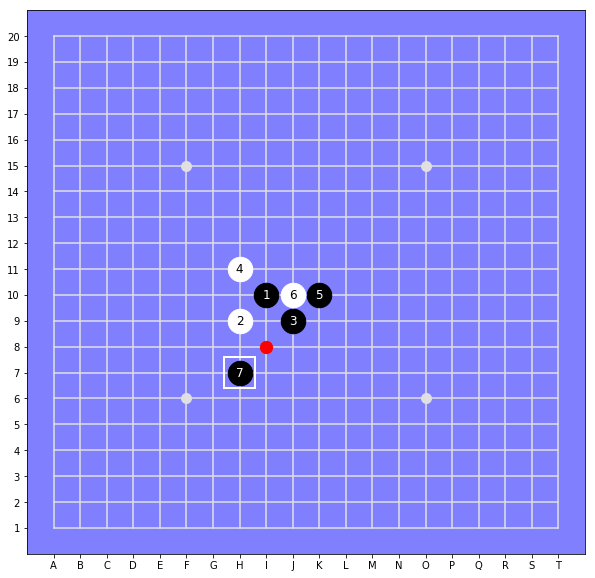

In [9]:
board.display(probas=lambda x: p.probas(x, 1))
board.get_value(True)

---
### Let the games begin!
We use a ```StochasticMaxSampler``` to sample from the board's distribution function . The idea behind the below self-play is that the players follow a common policy that handles critical situations appropriately and suggests kind of value-based moves, otherwise. Both parties check the field for potential threat sequences before they engage in rather loose (bias=0.5) tactical moves.

In [10]:
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, 
                          threat_search=ThreatSearch(6,5))
board.set(I,10).set(H,9)#.set(J,9).set(H,11).set(K,10).set(J,10);
ts = ThreatSearch(max_depth=4, max_width=5)

In [11]:
def play(board, p, N, ts):
    colors = ['Black', 'White']
    for i in range(N):
        moves, won = ts.is_tseq_won(board)
        if won:
            x, y = moves[0]
            #print ("Thread sequence: %s: " % moves)
        else:
            probas = p.probas(board, 2)
            sampler = StochasticMaxSampler(np.ndenumerate(probas), bias=0.5, topn=5)
            move = sampler.draw()
            x, y = gt.m2b(move, size=20)
        board.set(x,y)

        status = board.game_state()
        if status == 1: 
            print("%s wins." % colors[1 - board.current_color])
            break
        elif status == -1: 
            print("%s lost." % colors[1 - board.current_color])
            break

In [12]:
%time play(board, p, 40, ts)
#board.display()

Black wins.
CPU times: user 27.9 s, sys: 757 ms, total: 28.7 s
Wall time: 28.7 s


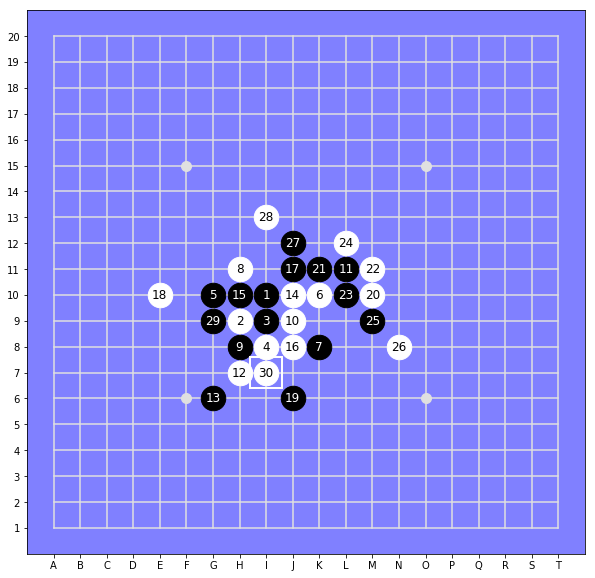

In [13]:
board.display()

In [15]:
print(gt.stones_to_string(board.stones))

i10h9i9i8g10k10k8h11h8j9l11h7g6j10h10j8j11e10j6m10k11m11l10l12m9n8j12i13g9i7


In [14]:
colors = ['Black', 'White']
status = board.game_state()
winner = int((status+1)/2) ^ board.current_color # wanna check the boolean table?
board.current_color, status, winner

(1, 1, 0)

In [59]:
gt.stones_to_string(board.stones)

'i10h9j9h11k10j10h7i8j7i7j8i6i5h6l6j6g6g9h8f9e9g10e8f11e12g11i11g8'

In [9]:
games = []
ts = ThreatSearch(max_depth=6, max_width=5)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ts)
for i in range(40):
    board = GomokuBoard(h, N=20, disp_width=10)
    board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(G,10);
    play(board, p, 40, ts)
    status = board.game_state()
    winner = int((status+1)/2) ^ board.current_color 
    string = gt.stones_to_string(board.stones)
    games.append([string, winner])

White wins.
White wins.
White wins.
White wins.
Black wins.
White wins.
Black wins.
White wins.
White wins.
White wins.
Black wins.
White wins.
Black wins.
White wins.
White wins.
Black wins.
White wins.
White wins.
White wins.
Black wins.
Black wins.
Black wins.
White wins.
White wins.
White wins.
White wins.
Black wins.
Black wins.
Black wins.
Black wins.
White wins.
White wins.
White wins.
Black wins.
Black wins.
Black wins.
White wins.
White wins.
Black wins.
White wins.


In [10]:
games

[['i10h9j9h11k10g10j7j10f9f11e12i11g11h12k9', 1],
 ['i10h9j9h11k10g10j7j10i12f11e12i11g11h12h10', 1],
 ['i10h9j9h11k10g10j7j10i12f11e12i11g11h12g13', 1],
 ['i10h9j9h11k10g10h10f9e8i12j13g9e9g11g12f11i11', 1],
 ['i10h9j9h11k10g10i8l11g6h7j10l10j8j7j11j12l8k8i11k9', 0],
 ['i10h9j9h11k10g10h10f9i12d7e8g9e9g11g8f11i11', 1],
 ['i10h9j9h11k10g10h7i8j7j10k8k7l7m6i6h5l9m10k9m9k12k11j5k4m8n7', 0],
 ['i10h9j9h11k10g10h7i8f11k6j7j10i12j11i7k7k4k9i11i13j5i6j6j8h10k8k5', 1],
 ['i10h9j9h11k10g10j7j10f9f11e12i11g11h12h10', 1],
 ['i10h9j9h11k10g10h7i8f11f9e8j7k6i12j13g9e9g12g11h12h10', 1],
 ['i10h9j9h11k10g10i8h7l11m12j10l10j8j7j11j12m8l9k11k8', 0],
 ['i10h9j9h11k10g10j7j10i12f11e12i11g11h12h10', 1],
 ['i10h9j9h11k10g10j7j10i8l11h7g6i7i9', 0],
 ['i10h9j9h11k10g10j7j10l11i8k8f11e12g11i11e11d11g8g9h8h10', 1],
 ['i10h9j9h11k10g10j7j10i12f11e12i11g11h12g13', 1],
 ['i10h9j9h11k10g10h7i8j7j10k8k7l7m6i6l9h5g4j5g8l3k4i5k5f5g5k6i4m8n9j4j6h6g7',
  0],
 ['i10h9j9h11k10g10h7i8f11h10h12i12f9f10e10g8j7j13k14j8h8g11

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(games, columns=['game', 'winner'])

In [13]:
df

,game,winner
0,i10h9j9h11k10g10j7j10f9f11e12i11g11h12k9,1
1,i10h9j9h11k10g10j7j10i12f11e12i11g11h12h10,1
2,i10h9j9h11k10g10j7j10i12f11e12i11g11h12g13,1
3,i10h9j9h11k10g10h10f9e8i12j13g9e9g11g12f11i11,1
4,i10h9j9h11k10g10i8l11g6h7j10l10j8j7j11j12l8k8i...,0
5,i10h9j9h11k10g10h10f9i12d7e8g9e9g11g8f11i11,1
6,i10h9j9h11k10g10h7i8j7j10k8k7l7m6i6h5l9m10k9m9...,0
7,i10h9j9h11k10g10h7i8f11k6j7j10i12j11i7k7k4k9i1...,1
8,i10h9j9h11k10g10j7j10f9f11e12i11g11h12h10,1
9,i10h9j9h11k10g10h7i8f11f9e8j7k6i12j13g9e9g12g1...,1


In [14]:
df.to_csv("self_play_data/startwith_i10h9j9h11k10g10_style_2_ts_65.csv")

In [16]:
import numpy as np
from wgomoku import (
    GomokuBoard, Move, StochasticMaxSampler, HeuristicGomokuPolicy, 
    ThreatSearch, Heuristics, GomokuTools as gt)
h = Heuristics(kappa=3.0)
ts = ThreatSearch(max_depth=6, max_width=5)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ts)

winner = -1
def play(board, p, N, ts):
    colors = ['Black', 'White']
    for i in range(N):
        moves, won = ts.is_tseq_won(board)
        if won:
            x, y = moves[0]
            #print ("Thread sequence: %s: " % moves)
        else:
            probas = p.probas(board, 2)
            sampler = StochasticMaxSampler(np.ndenumerate(probas), bias=0.5, topn=5)
            move = sampler.draw()
            x, y = gt.m2b(move, size=19)
        board.set(x,y)

        status = board.game_state()
        if status == 1: 
            winner = 1 - board.current_color
            break
        elif status == -1: 
            winner = board.current_color
            break
      
    
for i in range(2):
    board = GomokuBoard(h, N=19, disp_width=10)
    board.set(10,10).set(9,9)
    play(board, p, 40, ts)
    status = board.game_state()
    print(gt.stones_to_string(board.stones)+ ", %s" % winner)

[(10, 10), (9, 9), (11, 10), (12, 11)]


ValueError: Position (12, 11) is occupied.